# COW ACTIVITY RECOGNITION - PIPELINE OPTIMISÉ

## Version améliorée utilisant TOUTES les données avec features enrichies

## 1. IMPORTS ET CONFIGURATION

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.utils import resample
from scipy.signal import find_peaks
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

# Configuration
WINDOW_SIZE_SEC = 5
SAMPLING_RATE_HZ = 25
SAMPLES_PER_WINDOW = int(WINDOW_SIZE_SEC * SAMPLING_RATE_HZ)
OVERLAP_RATIO = 0.75  # Augmenté de 0.5 à 0.75 pour plus de fenêtres
BATCH_SIZE = 128  # Augmenté pour traiter plus de données
NUM_EPOCHS = 100
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_MIXUP = True  # Augmentation des données
MIXUP_ALPHA = 0.2

print(f"Using device: {DEVICE}")
print(f"Configuration: Window={WINDOW_SIZE_SEC}s, Overlap={OVERLAP_RATIO*100}%, Batch={BATCH_SIZE}")

Using device: cpu
Configuration: Window=5s, Overlap=75.0%, Batch=128


## 2. CHARGEMENT DES DONNÉES

In [3]:
print("\n" + "="*60)
print("CHARGEMENT DES DONNÉES")
print("="*60)

base_url = 'https://younescsvbuket.s3.eu-central-1.amazonaws.com/cow{}.csv'
cow_ids = range(1, 7)
df_list = []

for i in cow_ids:
    url = base_url.format(i)
    print(f"Loading cow{i} from: {url}")
    try:
        df_temp = pd.read_csv(url)
        df_temp['CowID'] = f'cow{i}'
        df_list.append(df_temp)
        print(f"  ✓ Loaded {len(df_temp)} samples")
    except Exception as e:
        print(f"  ✗ Error loading cow{i}: {e}")

if df_list:
    df = pd.concat(df_list, ignore_index=True)
    print(f"\n✓ Total samples loaded: {len(df)}")
else:
    raise ValueError("No data loaded.")


CHARGEMENT DES DONNÉES
Loading cow1 from: https://younescsvbuket.s3.eu-central-1.amazonaws.com/cow1.csv
  ✓ Loaded 311876 samples
Loading cow2 from: https://younescsvbuket.s3.eu-central-1.amazonaws.com/cow2.csv
  ✓ Loaded 269772 samples
Loading cow3 from: https://younescsvbuket.s3.eu-central-1.amazonaws.com/cow3.csv
  ✓ Loaded 269903 samples
Loading cow4 from: https://younescsvbuket.s3.eu-central-1.amazonaws.com/cow4.csv
  ✓ Loaded 224912 samples
Loading cow5 from: https://younescsvbuket.s3.eu-central-1.amazonaws.com/cow5.csv
  ✓ Loaded 134904 samples
Loading cow6 from: https://younescsvbuket.s3.eu-central-1.amazonaws.com/cow6.csv
  ✓ Loaded 179857 samples

✓ Total samples loaded: 1391224


## 3. PRÉTRAITEMENT

In [4]:
print("\n" + "="*60)
print("PRÉTRAITEMENT")
print("="*60)

df.dropna(inplace=True)
allowed_labels = ['ETC', 'RES', 'RUS', 'MOV', 'GRZ', 'SLT']
df = df[df['Label'].isin(allowed_labels)]

print(f"Data after cleaning: {len(df)} samples")
print("\nDistribution initiale:")
print(df['Label'].value_counts())

# Équilibrage intelligent (moins agressif)
print("\nÉquilibrage des classes...")
df_etc = df[df['Label'] == 'ETC']
df_res = df[df['Label'] == 'RES']
df_rus = df[df['Label'] == 'RUS']
df_mov = df[df['Label'] == 'MOV']
df_grz = df[df['Label'] == 'GRZ']
df_slt = df[df['Label'] == 'SLT']

# Sous-échantillonner ETC moins agressivement
df_etc_sampled = resample(df_etc, replace=False, n_samples=250000, random_state=42)
# Sur-échantillonner les minoritaires
df_slt_sampled = resample(df_slt, replace=True, n_samples=50000, random_state=42)
df_grz_sampled = resample(df_grz, replace=True, n_samples=50000, random_state=42)

df_balanced = pd.concat([
    df_etc_sampled, df_res, df_rus, df_mov, df_grz_sampled, df_slt_sampled
])

print(f"Balanced DataFrame: {df_balanced.shape[0]} samples")
print("\nDistribution équilibrée:")
print(df_balanced['Label'].value_counts())


PRÉTRAITEMENT
Data after cleaning: 836884 samples

Distribution initiale:
Label
ETC    554855
RES    150130
RUS     53229
MOV     50199
GRZ     17613
SLT     10858
Name: count, dtype: int64

Équilibrage des classes...
Balanced DataFrame: 603558 samples

Distribution équilibrée:
Label
ETC    250000
RES    150130
RUS     53229
MOV     50199
GRZ     50000
SLT     50000
Name: count, dtype: int64


## 4. EXTRACTION DE FEATURES ENRICHIES

In [5]:
def extract_enhanced_features(window_data):
    """
    Extraction de features enrichies pour chaque fenêtre
    Environ 100+ features par fenêtre
    """
    features = []

    for i in range(3):  # Pour chaque axe (X, Y, Z)
        signal = window_data[:, i]

        # === STATISTIQUES DE BASE ===
        features.extend([
            np.mean(signal),
            np.std(signal),
            np.var(signal),
            np.min(signal),
            np.max(signal),
            np.ptp(signal),  # Peak to peak (range)
            np.median(signal)
        ])

        # === STATISTIQUES AVANCÉES ===
        try:
            features.append(stats.skew(signal))
            features.append(stats.kurtosis(signal))
        except:
            features.extend([0, 0])

        # === PERCENTILES ===
        features.extend(np.percentile(signal, [10, 25, 75, 90]))

        # === ENERGY FEATURES ===
        features.extend([
            np.sum(signal**2),  # Energy
            np.sum(np.abs(signal)),  # Total absolute
            np.sqrt(np.mean(signal**2)),  # RMS
            np.mean(np.abs(signal))  # Mean absolute
        ])

        # === ZERO CROSSINGS ===
        zero_crossings = np.sum(np.diff(np.sign(signal)) != 0)
        features.append(zero_crossings)

        # === PEAK DETECTION ===
        peaks, _ = find_peaks(signal, distance=5)
        features.append(len(peaks))
        if len(peaks) > 0:
            features.append(np.mean(signal[peaks]))  # Mean peak value
        else:
            features.append(0)

        # === AUTOCORRELATION (plusieurs lags) ===
        if len(signal) > 20:
            autocorr = np.correlate(signal - np.mean(signal),
                                   signal - np.mean(signal), mode='full')
            autocorr = autocorr[len(autocorr)//2:]
            denom = autocorr[0] if autocorr[0] != 0 else 1e-10
            autocorr = autocorr / denom
            for lag in [1, 5, 10, 20]:
                features.append(autocorr[lag] if len(autocorr) > lag else 0)
        else:
            features.extend([0, 0, 0, 0])

        # === FREQUENCY DOMAIN (FFT) ===
        if len(signal) > 0:
            fft_vals = np.fft.fft(signal)
            freqs = np.fft.fftfreq(len(signal), d=1/SAMPLING_RATE_HZ)
            fft_magnitudes = np.abs(fft_vals[:len(signal)//2])
            positive_freqs = freqs[:len(signal)//2]

            if len(fft_magnitudes) > 0 and np.max(fft_magnitudes) > 0:
                # Dominant frequency
                dom_freq = positive_freqs[np.argmax(fft_magnitudes)]
                features.append(dom_freq)

                # Spectral percentiles
                features.extend(np.percentile(fft_magnitudes, [25, 50, 75, 90]))

                # Spectral entropy
                norm_mags = fft_magnitudes / (np.sum(fft_magnitudes) + 1e-10)
                spec_entropy = stats.entropy(norm_mags + 1e-10)
                features.append(spec_entropy)

                # Spectral centroid
                spec_centroid = np.sum(positive_freqs * fft_magnitudes) / (np.sum(fft_magnitudes) + 1e-10)
                features.append(spec_centroid)

                # Spectral spread
                spec_spread = np.sqrt(np.sum(((positive_freqs - spec_centroid)**2) * fft_magnitudes) /
                                     (np.sum(fft_magnitudes) + 1e-10))
                features.append(spec_spread)
            else:
                features.extend([0] * 8)
        else:
            features.extend([0] * 8)

    # === CROSS-AXIS FEATURES ===
    acc_x, acc_y, acc_z = window_data[:, 0], window_data[:, 1], window_data[:, 2]

    # Correlations entre axes
    features.append(np.corrcoef(acc_x, acc_y)[0, 1] if not np.isnan(np.corrcoef(acc_x, acc_y)[0, 1]) else 0)
    features.append(np.corrcoef(acc_x, acc_z)[0, 1] if not np.isnan(np.corrcoef(acc_x, acc_z)[0, 1]) else 0)
    features.append(np.corrcoef(acc_y, acc_z)[0, 1] if not np.isnan(np.corrcoef(acc_y, acc_z)[0, 1]) else 0)

    # Signal Magnitude Area (SMA)
    sma = np.sum(np.abs(acc_x) + np.abs(acc_y) + np.abs(acc_z))
    features.append(sma)

    # Signal Vector Magnitude (SVM)
    svm_values = np.sqrt(acc_x**2 + acc_y**2 + acc_z**2)
    features.extend([
        np.mean(svm_values),
        np.std(svm_values),
        np.max(svm_values)
    ])

    # Tilt angles
    features.append(np.mean(np.arctan2(acc_y, np.sqrt(acc_x**2 + acc_z**2))))
    features.append(np.mean(np.arctan2(acc_x, np.sqrt(acc_y**2 + acc_z**2))))

    return features

## 5. CRÉATION DES FENÊTRES (TOUTES LES DONNÉES)

In [6]:
print("\n" + "="*60)
print("CRÉATION DES FENÊTRES ET EXTRACTION DES FEATURES")
print("="*60)

all_features = []
segmented_labels = []
cow_id_list = []

step_size = int(SAMPLES_PER_WINDOW * (1 - OVERLAP_RATIO))
print(f"Step size: {step_size} samples ({step_size/SAMPLING_RATE_HZ:.2f}s)")

for cow_id in df_balanced['CowID'].unique():
    print(f"\nProcessing {cow_id}...")
    cow_df = df_balanced[df_balanced['CowID'] == cow_id].sort_values(by='TimeStamp_UNIX').reset_index(drop=True)
    num_samples = len(cow_df)
    windows_created = 0

    for start_idx in range(0, num_samples - SAMPLES_PER_WINDOW + 1, step_size):
        end_idx = start_idx + SAMPLES_PER_WINDOW

        window_data = cow_df.loc[start_idx:end_idx-1, ['AccX', 'AccY', 'AccZ']].values
        window_labels = cow_df.loc[start_idx:end_idx-1, 'Label']

        # CHANGEMENT MAJEUR: Garder TOUTES les fenêtres
        # Prendre simplement l'étiquette majoritaire
        most_frequent_label = window_labels.mode()[0]

        # Extraire les features
        try:
            features = extract_enhanced_features(window_data)
            all_features.append(features)
            segmented_labels.append(most_frequent_label)
            cow_id_list.append(cow_id)
            windows_created += 1
        except Exception as e:
            continue

    print(f"  ✓ Created {windows_created} windows")

X_features = np.array(all_features)
print(f"\n✓ Total windows created: {X_features.shape[0]}")
print(f"✓ Features per window: {X_features.shape[1]}")


CRÉATION DES FENÊTRES ET EXTRACTION DES FEATURES
Step size: 31 samples (1.24s)

Processing cow1...
  ✓ Created 3199 windows

Processing cow5...
  ✓ Created 1515 windows

Processing cow2...
  ✓ Created 4323 windows

Processing cow6...
  ✓ Created 3008 windows

Processing cow4...
  ✓ Created 2684 windows

Processing cow3...
  ✓ Created 4720 windows

✓ Total windows created: 19449
✓ Features per window: 105


## 6. PRÉPARATION DES DATASETS

In [7]:
print("\n" + "="*60)
print("PRÉPARATION DES DATASETS")
print("="*60)

# Encoder les labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(segmented_labels)
print(f"Classes: {label_encoder.classes_}")
print(f"Distribution des fenêtres par classe:")
for cls in label_encoder.classes_:
    count = np.sum(np.array(segmented_labels) == cls)
    print(f"  {cls}: {count} fenêtres")

# Split stratifié
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_features, y_encoded, test_size=0.15, random_state=42, stratify=y_encoded
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=(0.15 / 0.85), random_state=42, stratify=y_train_val
)

# Normalisation (CRITIQUE: fit sur train uniquement)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Conversion en tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

print(f"\n✓ Train: {X_train_tensor.shape[0]} samples")
print(f"✓ Val: {X_val_tensor.shape[0]} samples")
print(f"✓ Test: {X_test_tensor.shape[0]} samples")


PRÉPARATION DES DATASETS
Classes: ['ETC' 'GRZ' 'MOV' 'RES' 'RUS' 'SLT']
Distribution des fenêtres par classe:
  ETC: 7957 fenêtres
  GRZ: 1626 fenêtres
  MOV: 1637 fenêtres
  RES: 4890 fenêtres
  RUS: 1726 fenêtres
  SLT: 1613 fenêtres

✓ Train: 13613 samples
✓ Val: 2918 samples
✓ Test: 2918 samples


## 7. DATASET ET DATALOADER

In [8]:
class CowDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

train_dataset = CowDataset(X_train_tensor, y_train_tensor)
val_dataset = CowDataset(X_val_tensor, y_val_tensor)
test_dataset = CowDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## 8. MODÈLE AMÉLIORÉ

In [9]:
class EnhancedActivityModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(EnhancedActivityModel, self).__init__()

        self.bn_input = nn.BatchNorm1d(input_dim)

        # Couche 1
        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.4)

        # Couche 2
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.4)

        # Couche 3
        self.fc3 = nn.Linear(128, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.dropout3 = nn.Dropout(0.3)

        # Couche 4
        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.dropout4 = nn.Dropout(0.3)

        # Shortcuts pour connexions résiduelles
        self.shortcut1 = nn.Linear(256, 128)
        self.shortcut2 = nn.Linear(128, 64)

        # Couche de sortie
        self.fc_out = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.bn_input(x)

        # Bloc 1
        out = self.relu(self.bn1(self.fc1(x)))
        out = self.dropout1(out)
        identity1 = out

        # Bloc 2
        out = self.relu(self.bn2(self.fc2(out)))
        out = self.dropout2(out)
        identity2 = out

        # Bloc 3 avec résiduel
        out = self.relu(self.bn3(self.fc3(out)))
        out = out + identity2
        out = self.dropout3(out)

        # Bloc 4 avec résiduel long
        out = self.relu(self.bn4(self.fc4(out)))
        out = out + self.shortcut2(identity2)
        out = self.dropout4(out)

        out = self.fc_out(out)
        return out

## 9. INITIALISATION DU MODÈLE

In [10]:
print("\n" + "="*60)
print("INITIALISATION DU MODÈLE")
print("="*60)

input_dim = X_train_tensor.shape[1]
num_classes = len(label_encoder.classes_)

model = EnhancedActivityModel(input_dim=input_dim, num_classes=num_classes).to(DEVICE)
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

# Poids des classes pour la loss
class_counts = pd.Series(y_train).value_counts().sort_index()
inverse_freq = 1.0 / (class_counts + 1)
class_weights = inverse_freq / inverse_freq.mean()
weights_tensor = torch.tensor(class_weights.values, dtype=torch.float32).to(DEVICE)

criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.01,
    epochs=NUM_EPOCHS,
    steps_per_epoch=len(train_loader),
    pct_start=0.3,
    anneal_strategy='cos'
)


INITIALISATION DU MODÈLE
EnhancedActivityModel(
  (bn_input): BatchNorm1d(105, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=105, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.4, inplace=False)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.3, inplace=False)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout4): Dropout(p=0.3, inplace=False)
  (shortcut1): Linear(in_features=256, out_features=128, bias=True)
  (sho

## 10. MIXUP AUGMENTATION

In [11]:
def mixup_data(x, y, alpha=0.2):
    """Mixup augmentation"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Loss pour mixup"""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

## 11. BOUCLE D'ENTRAÎNEMENT

In [12]:
print("\n" + "="*60)
print("ENTRAÎNEMENT")
print("="*60)

train_losses = []
val_losses = []
best_val_acc = 0
patience = 15
patience_counter = 0

for epoch in range(NUM_EPOCHS):
    # === TRAINING ===
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        # Appliquer Mixup
        if USE_MIXUP and np.random.rand() > 0.5:
            inputs, labels_a, labels_b, lam = mixup_data(inputs, labels, MIXUP_ALPHA)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
            loss.backward()
            optimizer.step()
            scheduler.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (lam * predicted.eq(labels_a).sum().float() +
                       (1 - lam) * predicted.eq(labels_b).sum().float()).item()
        else:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(avg_train_loss)

    # === VALIDATION ===
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct_val / total_val
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}: "
          f"Train Loss={avg_train_loss:.4f}, Acc={train_acc:.2f}% | "
          f"Val Loss={avg_val_loss:.4f}, Acc={val_acc:.2f}%")

    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping à l'epoch {epoch+1}")
            break

# Charger le meilleur modèle
model.load_state_dict(torch.load('best_model.pth'))


ENTRAÎNEMENT
Epoch 1/100: Train Loss=0.9270, Acc=56.76% | Val Loss=0.3557, Acc=80.74%
Epoch 2/100: Train Loss=0.5221, Acc=80.49% | Val Loss=0.2397, Acc=88.69%
Epoch 3/100: Train Loss=0.4775, Acc=82.87% | Val Loss=0.2103, Acc=90.13%
Epoch 4/100: Train Loss=0.4044, Acc=85.37% | Val Loss=0.1948, Acc=89.99%
Epoch 5/100: Train Loss=0.4031, Acc=85.19% | Val Loss=0.1915, Acc=90.61%
Epoch 6/100: Train Loss=0.3984, Acc=85.62% | Val Loss=0.1783, Acc=91.43%
Epoch 7/100: Train Loss=0.4213, Acc=85.21% | Val Loss=0.1856, Acc=91.60%
Epoch 8/100: Train Loss=0.3987, Acc=85.20% | Val Loss=0.1827, Acc=91.09%
Epoch 9/100: Train Loss=0.4320, Acc=84.70% | Val Loss=0.1995, Acc=90.13%
Epoch 10/100: Train Loss=0.3548, Acc=87.32% | Val Loss=0.1811, Acc=91.06%
Epoch 11/100: Train Loss=0.3857, Acc=86.27% | Val Loss=0.2013, Acc=90.30%
Epoch 12/100: Train Loss=0.3852, Acc=86.70% | Val Loss=0.1749, Acc=90.92%
Epoch 13/100: Train Loss=0.3929, Acc=85.94% | Val Loss=0.2057, Acc=90.78%
Epoch 14/100: Train Loss=0.4015, 

<All keys matched successfully>

## 12. ÉVALUATION FINALE


ÉVALUATION SUR LE TEST SET

Classification Report:
              precision    recall  f1-score   support

         ETC       0.95      0.94      0.95      1194
         GRZ       0.98      1.00      0.99       244
         MOV       0.79      0.94      0.86       245
         RES       0.96      0.87      0.91       734
         RUS       0.90      0.98      0.94       259
         SLT       1.00      1.00      1.00       242

    accuracy                           0.94      2918
   macro avg       0.93      0.96      0.94      2918
weighted avg       0.94      0.94      0.94      2918


ACCURACY FINALE: 93.76%


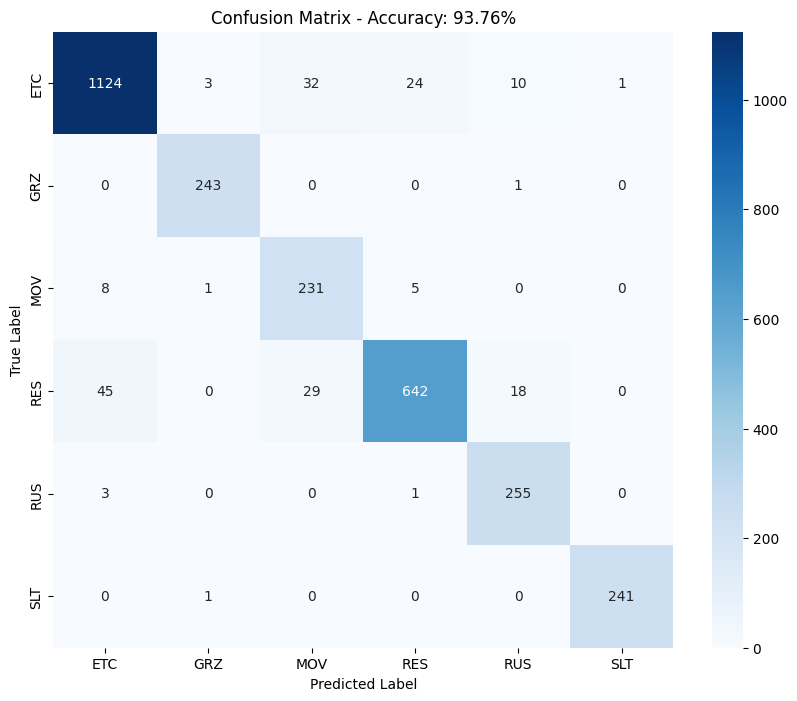

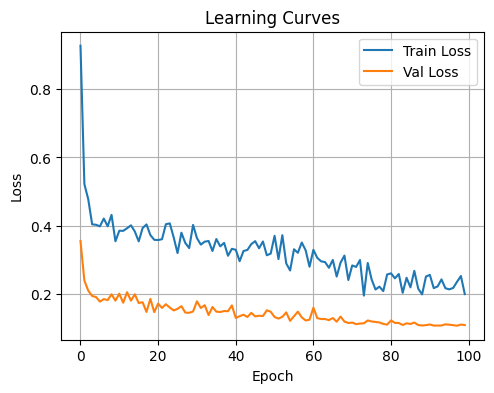


✓ Pipeline terminé avec succès!


In [13]:
print("\n" + "="*60)
print("ÉVALUATION SUR LE TEST SET")
print("="*60)

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Rapport de classification
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

# Accuracy finale
final_accuracy = accuracy_score(all_labels, all_preds)
print(f"\n{'='*60}")
print(f"ACCURACY FINALE: {final_accuracy*100:.2f}%")
print(f"{'='*60}")

# Matrice de confusion
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix - Accuracy: {final_accuracy*100:.2f}%')
plt.show()

# Courbes d'apprentissage
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curves')
plt.grid(True)
plt.show()

print("\n✓ Pipeline terminé avec succès!")